In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import torch
import re
from my_utils_v2 import *

In [2]:
tissue_path='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set06/GCA007ACB/Registered'
tissue_name='GCA007ACB'
mask_path=f'/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set06/GCA007ACB/Registered/{tissue_name}_RetentionMask.tif'

In [3]:
file_names = os.listdir(tissue_path)

# Filter the list to only include files named {tissue_name}_DAPI
dapi_files = [file for file in file_names if f'{tissue_name}_DAPI' in file]
dapi_files_sorted = sorted(dapi_files, key=lambda file: int(re.search('ROUND_(\\d+)', file).group(1)))

In [4]:
round0_dapi_for_composition=os.path.join(tissue_path,dapi_files_sorted[0])
round_last_dapi_for_composition=os.path.join(tissue_path,dapi_files_sorted[-1])
Retention_Mask=np.array(Image.open(mask_path))

block_size = 1024

round0_dapi_for_composition=np.array(Image.open(round0_dapi_for_composition)) / 255.
round_last_dapi_for_compositin=np.array(Image.open(round_last_dapi_for_composition)) /255.
round0_dapi_for_composition = round0_dapi_for_composition * Retention_Mask
round_last_dapi_for_compositin = round_last_dapi_for_compositin * Retention_Mask
original_height, original_width = round0_dapi_for_composition.shape

pad_size0 = block_size - round0_dapi_for_composition.shape[0] % block_size
pad_size1 = block_size - round0_dapi_for_composition.shape[1] % block_size

# Pad the images
round0_dapi_for_composition = np.pad(round0_dapi_for_composition, ((0, pad_size0), (0, pad_size1)))
round_last_dapi_for_compositin = np.pad(round_last_dapi_for_compositin, ((0, pad_size0), (0, pad_size1)))

model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/Smoothness_1_epochs/epoch_15/epoch_15.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
L2_norm=Utils_v2.L2_norm_mask(round0_dapi_for_composition,round_last_dapi_for_compositin,model,device)

In [6]:
mask = L2_norm > 10

mask_image = (mask * 255).astype(np.uint8)

In [7]:
round0_dapi_for_composition[mask_image == 255] = 0
mask_image=mask_image[:original_height,:original_width]
round0_dapi_for_composition=round0_dapi_for_composition[:original_height,:original_width]

In [8]:
from tqdm import tqdm
registered_path='/fs5/p_masi/rudravg/test_means_2/Registered'
unregistered_path='/fs5/p_masi/rudravg/test_means_2/Unregistered'
mask_image=mask_image[:original_height,:original_width]
os.mkdir(registered_path)
os.mkdir(unregistered_path)
round0_dapi=dapi_files_sorted[0]
round0_dapi=os.path.join(tissue_path,round0_dapi)
round0_dapi,_,_=Utils_v2.load_tissues_for_overlap(round0_dapi,mask_path)

height, width = round0_dapi.shape

# Calculate the padding sizes
pad_height = height - mask_image.shape[0]
pad_width = width - mask_image.shape[1]

# Add zero padding to mask_image
mask_image = np.pad(mask_image, ((0, pad_height), (0, pad_width)))

round0_dapi[mask_image==255]=0
for file_names in tqdm(dapi_files_sorted[1:]):
    round_dapi=os.path.join(tissue_path,file_names) #Path for the round of dapi
    round_dapi,_,_=Utils_v2.load_tissues_for_overlap(round_dapi,mask_path) #Loading the round of dapi
    round_dapi[mask_image==255]=0 #Masking the round of dapi
    registered_dapi=Utils_v2.register_multiple_tissues_with_overlap(
                                                                    dapi_round_last=round_dapi,
                                                                    dapi_round0=round0_dapi,
                                                                    model=model,
                                                                    device=device) #Registering the round of dapi
    registered_dapi=registered_dapi[:original_height,:original_width] #Cropping the registered dapi
    registered_adjusted_dapi,factor=Utils_v2.adjust_intensity(round0_dapi_for_composition,registered_dapi) #Adjusting the intensity of the registered dapi

    round_dapi_adjusted=round_dapi*factor #Adjusting the intensity of the round 0 dapi
    round_dapi_adjusted=np.minimum(round_dapi_adjusted,1) #Clipping the values to 1

    Image.fromarray(np.uint8(registered_adjusted_dapi*255)).save(os.path.join(registered_path,file_names))
    Image.fromarray(np.uint8(round_dapi_adjusted*255)).save(os.path.join(unregistered_path,file_names))


  0%|          | 0/19 [00:00<?, ?it/s]/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils_v2.py:22: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)
/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils_v2.py:22: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)
100%|██████████| 19/19 [02:42<00:00,  8.53s/it]


In [9]:
registered_files=os.listdir(registered_path)

images = []

for file in registered_files:
    img_path = os.path.join(registered_path, file)
    img = np.array(Image.open(img_path))
    images.append(img)

stacked_images = np.stack(images)

pixel_wise_mean = np.mean(stacked_images, axis=0)

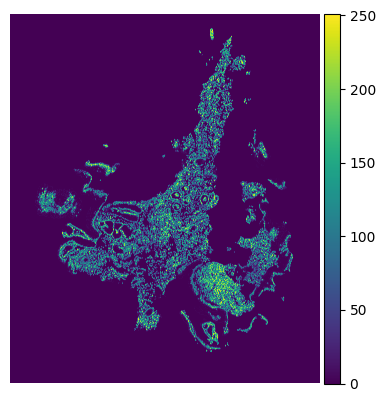

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
im = ax.imshow(pixel_wise_mean, cmap='viridis')
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
plt.show()

In [11]:
pixel_wise_std = np.std(stacked_images, axis=0)

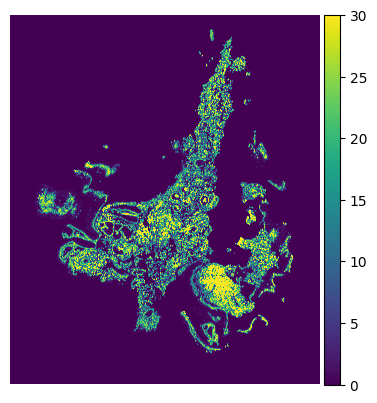

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(pixel_wise_std, cmap='viridis',vmax=30)
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
plt.show()

In [13]:
unregistered_files=os.listdir(unregistered_path)
unregistered_images = []
for file in unregistered_files:
    img_path = os.path.join(unregistered_path, file)
    img = np.array(Image.open(img_path))
    unregistered_images.append(img)

stacked_images_unregistered = np.stack(unregistered_images)


In [14]:
pixel_wise_mean_unregistered = np.mean(stacked_images_unregistered, axis=0)
pixel_wise_std_unregistered = np.std(stacked_images_unregistered, axis=0)

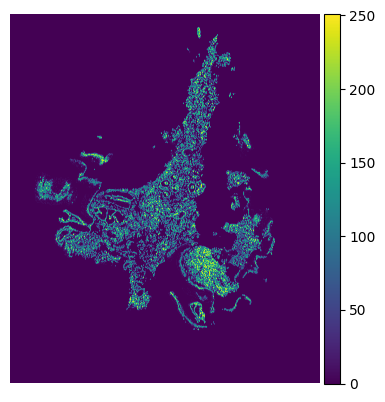

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(pixel_wise_mean_unregistered, cmap='viridis')
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
plt.show()

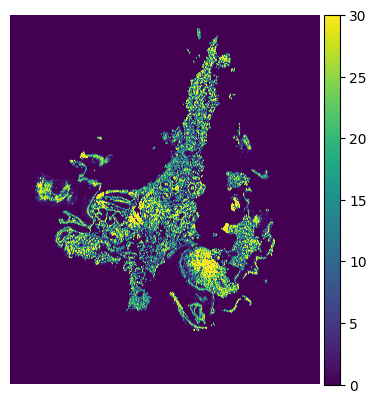

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(pixel_wise_std_unregistered, cmap='viridis',vmax=50)
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(im, cax=cax)
plt.show()